**Classification of text documents using sparse features**

This example demonstrates the use of scikit-learn to classify documents by topics using a Bag Of Words approach.

**Loading and vectorizing the 20 newsgroup dataset**

We use The 20 newsgroups text dataset which comprises around 18,000 newsgroups posts on 20 topics split into two subsets: one for training (or development) and the other for testing (or performance evaluation). By default, the text samples contain some message metadata such as 'headers', 'footers' and 'quotes'. The fetch_20newsgroups function accepts a parameter named 'remove' to strip such information that can make the classification problem 'too easy'. 

In [8]:
from time import time 

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer

categories = [
    'alt.atheism',
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]


def size_mb(docs):
    return sum(len(s.encode('utf-8')) for s in docs)/1e6

def load_dataset(verbose = False, remove = ()):
    """Loading and vectorizing the 20 newsgroup dataset"""
    
    data_train = fetch_20newsgroups(
        subset = 'train',
        categories = categories, 
        shuffle = True, 
        random_state=42, 
        remove = remove
    )
    
    data_test = fetch_20newsgroups(
        subset = 'test',
        categories = categories, 
        shuffle = True, 
        random_state=42, 
        remove = remove
    )
    
    #order of labels in 'target_names' can be different from categories
    
    target_names = data_train.target_names #category names
    
    #Splitting the target in a training set and a test set
    
    y_train, y_test = data_train.target, data_test.target  #.target = numerical labels 
    
    #Extracting features from the training data using the sparse vectorizer
    
    t0 = time()
    
    vectorizer = TfidfVectorizer(sublinear_tf = True, max_df = 0.5, min_df = 5, stop_words = 'english')
    
    X_train  = vectorizer.fit_transform(data_train.data) #.data - the actual text of documents in the training set
    
    duration_train = time() - t0
    
    #Extracting features from the test data  using the TFIDFvectorizer
    
    t0 = time()
    
    X_test = vectorizer.transform(data_test.data)
    
    duration_test = time() - t0
    
    feature_names = vectorizer.get_feature_names_out()
    
    if verbose: 
        
        #compute the size of loaded data
        
        data_train_size_mb = size_mb(data_train.data)
        data_test_size_mb = size_mb(data_test.data)
        
        print(
        f'{len(data_train.data)} documents - '
        f'{data_train_size_mb:.2f}MB (training set)'
         )
    
        print(
        f'{len(data_test.data)} documents - '
        f'{data_test_size_mb:.2f}MB (testing set)'
        )
    
        print(f'{len(target_names)} categories')

        print(f'vectorize training done in {duration_train:.3f}s'
          f'at {data_train_size_mb / duration_train:.3f} MB/s')
    
        print(f'n_samples: {X_train.shape[0]}, n_features: {X_test.shape[1]}')
    
        print(f'vectorize testing done in {duration_test:.3f}s'
          f'at {data_test_size_mb / duration_test:.3f} MB/s')
    return X_train, X_test, y_train, y_test, feature_names, target_names
    

**Analysis of a bag-of-words document classifier**

We will train the classifier twice, once on the text samples containing metadata and once after stripping the metadata. For both cases, we will analyze the classification error on the test set using a confusion matrix and examine the coefficients that define the classification function of the trained models. 

(I) Model without stripping metadata

In [9]:
#Loading the data using the custom function load_dataset

X_train, X_test, y_train, y_test, feature_names, target_names = load_dataset(verbose = True)

2034 documents - 3.98MB (training set)
1353 documents - 2.87MB (testing set)
4 categories
vectorize training done in 0.176sat 22.641 MB/s
n_samples: 2034, n_features: 7831
vectorize testing done in 0.119sat 24.082 MB/s


The first model is an instance of the RidgeClassifier. This is a linear classification model that uses the MSE on {-1,1} encoded targets, one for each possible class. 

In [10]:
from sklearn.linear_model import RidgeClassifier

clf = RidgeClassifier(tol = 1e-2, solver = "sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

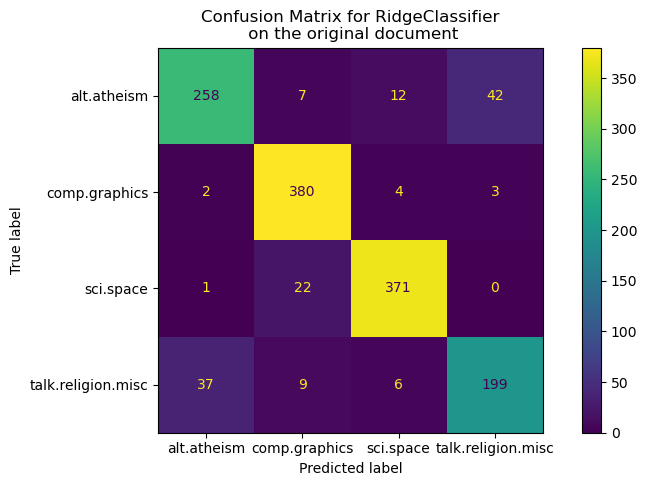

In [11]:
#Plotting the confusion matrix of the classifier to find a pattern in the classification errors

import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay

fig,ax = plt.subplots(figsize = (10,5))

ConfusionMatrixDisplay.from_predictions(y_test, pred, ax = ax)

ax.xaxis.set_ticklabels(target_names)

ax.yaxis.set_ticklabels(target_names)

_ = ax.set_title(f'Confusion Matrix for {clf.__class__.__name__}\n on the original document')

The confusion matrix suggests that the documents of the alt.atheism class are often confused with documents in the class talk.religion.misc class and vice-versa which is expected since the topics are semantically related. It can also be observed that some documents of the sci.space class can be classified as comp.graphics while the converse is much rarer. It could be because the vocabulary of the space topics could be more specific than the ones for computer graphics. 



In [ ]:
import numpy as np
import pandas as pd

def plot_feature_effects():
    
    #learned coefficients weighted by frequency of appearance
    
    average_feature_effects = clf.coef_ * np.asarray(X_train.mean(axis = 0)).ravel() #takes into account frequency and importance of the features (words)
    
    for i, label in enumerate(target_names):
        top5 = np.argsort(average_feature_effects[i])